# Optimization Tutorial

Trey V. Wenger (c) June 2024

Here we demonstrate how to optimize the number of cloud components in a `mcmc_yplus` model. We start by importing the package and generating some example data.

In [1]:
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

import mcmc_yplus
from mcmc_yplus.optimize import Optimize
from mcmc_yplus.plots import plot_pair

print("mcmc_yplus:", mcmc_yplus.__version__)

pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

mcmc_yplus: 0.0.2b


In [2]:
# Generate synthetic data
poly_coeffs = [1.0e-7, -2.0e-6, 0.0, 0.1]
H_centers = [-15.0, 20.0]
H_fwhms = [30.0, 35.0]
H_peaks = [10.0, 20.0]
He_H_fwhm_ratios = [0.9, 0.75]
ypluses = [0.06, 0.09]
He_offset = 122.15

channel = np.linspace(-300.0, 200.0, 1000)
rms = 1.0
spectrum = rng.normal(loc=0.0, scale=rms, size=1000)
spectrum += np.polyval(poly_coeffs, channel)
for H_center, H_fwhm, H_peak, He_H_fwhm_ratio, yplus in zip(H_centers, H_fwhms, H_peaks, He_H_fwhm_ratios, ypluses):
    # H component
    spectrum += H_peak * np.exp(-4.0 * np.log(2.0) * (channel - H_center)**2.0 / H_fwhm**2.0)
    
    # He component
    He_fwhm = H_fwhm * He_H_fwhm_ratio
    He_peak = H_peak * yplus / He_H_fwhm_ratio
    He_center = H_center - He_offset
    spectrum += He_peak * np.exp(-4.0 * np.log(2.0) * (channel - He_center)**2.0 / He_fwhm**2.0)
    
data = {
    "velocity": channel,
    "spectrum": spectrum,
    "noise": np.ones_like(spectrum) * rms,
}
print(data.keys())

dict_keys(['velocity', 'spectrum', 'noise'])


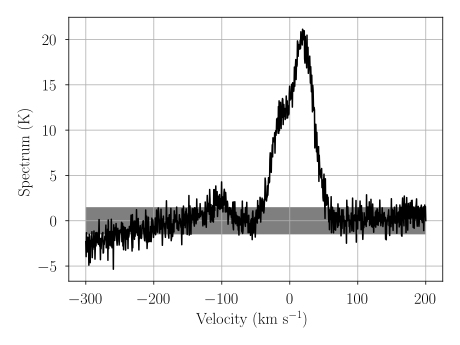

In [3]:
# Plot example data
fig, ax0 = plt.subplots()
ax0.plot(data["velocity"], data["spectrum"], "k-")
ax0.fill_between(
    data["velocity"],
    -1.5 * data["noise"],
    1.5 * data["noise"],
    color="k",
    edgecolor="none",
    lw=0,
    alpha=0.5,
)
ax0.set_ylabel("Spectrum (K)")
ax0.set_xlabel(r"Velocity (km s$^{-1}$)")
fig.tight_layout()
fig.savefig(f"{figdir}/data.{ext}")
plt.close(fig)

SVG(f"{figdir}/data.{ext}")

## `Optimize`

We use the `Optimize` class for optimization.

In [4]:
opt = Optimize(
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=3,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)
opt.set_priors(
    prior_H_amplitude = 10.0, # sigma of half-normal distribution (K)
    prior_H_center = [0.0, 25.0], # center and sigma of normal distribution (km s-1)
    prior_H_fwhm = 20.0, # mode of k=4 gamma distribution (km s-1)
    prior_yplus = 0.1, # sigma of half-normal distribution
    prior_He_H_fwhm_ratio = 0.1, # sigma of unity-centered truncated normal distribution
)

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [5]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default, with `approx=True`, the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. Whichever model has the lowest BIC is then sampled with MCMC. We can supply arguments to `fit` and `sample` via dictionaries. `bic_threshold` is a hyperparameter that allows for fewer component models to be the "best" model, as long as they're within this threshold of the minimum BIC.

In [6]:
fit_kwargs = {
    "learning_rate": 1e-2,
    "abs_tolerance": 0.03,
    "rel_tolerance": 0.03,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs, bic_threshold=10.0)

Null hypothesis BIC = 1.974e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 8000
Interrupted at 7,999 [7%]: Average Loss = 2,618.8


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 3.642e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 76100
Interrupted at 76,099 [76%]: Average Loss = 1,568.5


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 2.904e+03

Approximating n_cloud = 3 posterior...


Output()

Finished [100%]: Average Loss = 1,441.4


GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 2.955e+03

Approximating n_cloud = 4 posterior...


Output()

Finished [100%]: Average Loss = 1,447


No solution found!
GMM found 0 unique solutions

Approximating n_cloud = 5 posterior...


Output()

Finished [100%]: Average Loss = 1,452.3


No solution found!
GMM found 0 unique solutions

Sampling best model (n_cloud = 2)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 76100
Interrupted at 76,099 [76%]: Average Loss = 1,568.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, H_amplitude, H_center, H_fwhm, yplus, He_H_fwhm_ratio]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


Only 3 chains appear converged.
GMM converged to unique solution


The "best" model is saved in `opt.best_model`.

In [7]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
display(az.summary(opt.best_model.trace.solution_0))

Best model has n_clouds = 2


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_amplitude[0],9.932,0.281,9.426,10.483,0.007,0.005,1822.0,2160.0,1.0
H_amplitude[1],19.898,0.194,19.524,20.248,0.004,0.002,3005.0,2243.0,1.0
H_center[0],-15.721,0.656,-16.909,-14.473,0.018,0.012,1432.0,1635.0,1.0
H_center[1],19.835,0.392,19.115,20.559,0.010,0.007,1432.0,1418.0,1.0
H_fwhm[0],29.050,1.171,26.863,31.167,0.029,0.020,1701.0,1877.0,1.0
H_fwhm[1],36.644,0.785,35.168,38.142,0.021,0.015,1468.0,1610.0,1.0
He_H_fwhm_ratio[0],1.006,0.094,0.823,1.168,0.001,0.001,3975.0,1945.0,1.0
He_H_fwhm_ratio[1],0.846,0.071,0.708,0.982,0.001,0.001,3088.0,2256.0,1.0
He_amplitude[0],0.772,0.185,0.431,1.114,0.004,0.003,2697.0,1771.0,1.0
He_amplitude[1],2.188,0.196,1.817,2.546,0.003,0.002,3320.0,2406.0,1.0


Alternatively, with `approx=False`, we use MCMC to sample each model. This is slower, but more accurate.

In [8]:
opt.optimize(sample_kwargs=sample_kwargs, approx=False)

Null hypothesis BIC = 1.974e+04
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8000
Interrupted at 7,999 [7%]: Average Loss = 2,618.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, H_amplitude, H_center, H_fwhm, yplus, He_H_fwhm_ratio]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 3.641e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 76100
Interrupted at 76,099 [76%]: Average Loss = 1,568.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, H_amplitude, H_center, H_fwhm, yplus, He_H_fwhm_ratio]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


Only 3 chains appear converged.
GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 2.902e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Finished [100%]: Average Loss = 1,441.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, H_amplitude, H_center, H_fwhm, yplus, He_H_fwhm_ratio]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 216 seconds.


Only 3 chains appear converged.
There were 117 divergences in converged chains.
GMM converged to unique solution
Chain label order mismatch in solution 0
Chain 1 order: [0 2 1]
Chain 2 order: [1 0 2]
Chain 3 order: [0 1 2]
Adopting (first) most common order: [0 1 2]
n_cloud = 3 solution = 0 BIC = 4.328e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Finished [100%]: Average Loss = 1,447
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, H_amplitude, H_center, H_fwhm, yplus, He_H_fwhm_ratio]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 277 seconds.


There were 399 divergences in converged chains.
No solution found!
GMM found 0 unique solutions

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Finished [100%]: Average Loss = 1,452.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, H_amplitude, H_center, H_fwhm, yplus, He_H_fwhm_ratio]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 338 seconds.


Only 3 chains appear converged.
There were 29 divergences in converged chains.
No solution found!
GMM found 0 unique solutions



The model with the lowest BIC is again stored in `opt.best_model`. We can confirm that it is the best model using a more robust model comparison technique: leave-one-out cross-validation, which estimates the out-of-sample predictive fit.

In [10]:
# Populate models with likelihood samples
import pymc as pm

for model in opt.models.values():
    with model.model:
        pm.compute_log_likelihood(model.trace)

Output()

Output()

Output()

Output()

Output()

In [13]:
loo = az.compare({n_gauss: model.trace for n_gauss, model in opt.models.items()})
print(loo)

   rank     elpd_loo      p_loo   elpd_diff        weight         se  \
2     0 -1399.312119  11.725324    0.000000  1.000000e+00  21.483065   
3     1 -1400.250447  12.757745    0.938328  1.567710e-09  21.508605   
4     2 -1401.209368  13.700372    1.897249  1.544262e-09  21.553661   
5     3 -1401.608724  14.294385    2.296605  1.532084e-09  21.538841   
1     4 -1791.711161  19.360549  392.399043  0.000000e+00  46.211076   

         dse  warning scale  
2   0.000000    False   log  
3   0.288333    False   log  
4   0.541052    False   log  
5   0.643225    False   log  
1  41.007012    False   log  


The model with the largest `elpd_loo` is prefered. In this case, only the `n_gauss=1` model is rejected, but the `n_gauss=2` model is the fewest-component model with a similar predictive fit (as approximated by the BIC).